<a href="https://colab.research.google.com/github/bob123kk/NLP-Question-Answering/blob/master/Kaggle_Q%26A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# from google.colab import files
# files.upload()  #this will prompt you to update the json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission

# !pip uninstall -y kaggle
# !pip install --upgrade pip
# !pip install kaggle==1.5.6
# !kaggle -v


# !kaggle --version


# !kaggle competitions download -c tensorflow2-question-answering 

# !unzip /content/simplified-nq-train.jsonl.zip
!pip install python-Levenshtein
!pip install contractions




     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144794 sha256=17c6380128adee78ce2baa290133add0cc42066bc798f2605d77116e012433f2
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein
     |████████████████████████████████| 245kB 5.6MB/s 
     |████████████████████████████████| 317kB 19.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81706 sha256=61cbe81e61cdfa95ea8cbbb52d75a71a45c73b6fa787da43f7137690b897c5d8
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


### Enabling and testing the GPU

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.2198475860000144
GPU (s):
0.05494764800005214
GPU speedup over CPU: 58x


## Import Libraries

In [0]:
import gc
import json
import numpy as np 
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.metrics import accuracy_score,recall_score, f1_score,confusion_matrix
from tqdm.notebook import tqdm
import Levenshtein

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression

from scipy import spatial
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



import contractions
from bs4 import BeautifulSoup

import re

import unicodedata







In [0]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(doc):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

## Pre-defined Functions and file Paths

In [0]:
html_tags = ['<P>', '</P>', '<Table>', '</Table>', '<Tr>', '</Tr>', '<Ul>', '<Ol>', '<Dl>', '</Ul>', '</Ol>', \
             '</Dl>', '<Li>', '<Dd>', '<Dt>', '</Li>', '</Dd>', '</Dt>']
r_buf = ['is', 'are', 'do', 'does', 'did', 'was', 'were', 'will', 'can', 'the', 'a', 'an', 'of', 'in', 'and', 'on', \
         'what', 'where', 'when', 'which'] + html_tags

def clean(x):
    x = x.lower()
    for r in r_buf:
        x = x.replace(r, '')
    x = re.sub(' +', ' ', x)
    return x


# pd.set_option('display.max_columns', 999)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.width', 999)


train_path = '/content/drive/My Drive/Q&A Data/tensorflow2-question-answering/simplified-nq-train.jsonl'
test_path = '/content/drive/My Drive/Q&A Data/tensorflow2-question-answering/simplified-nq-test.jsonl'
sample_sub  = '/content/drive/My Drive/Q&A Data/tensorflow2-question-answering/sample_submission.csv'

# Read Data


In [0]:
def read_data(path,sample = True, size = 10):
  if sample == True:
    df = []
    with open(path, 'rt') as reader:
      for i in range(size):
        df.append(json.loads(reader.readline()))

      df = pd.DataFrame(df)
      print('sampled data have {} rows and {} cols'.format(df.shape[0],df.shape[1]))
  else:
    df = pd.read_json(path,orient = 'records', lines = True)
    print('sampled data have {} rows and {} cols'.format(df.shape[0],df.shape[1]))
    gc.collect()
  return df

train_pre = read_data(train_path, sample = True)
test_pre = read_data(test_path, sample = False)
#print(train_pre.head())
print(test_pre.head())

sampled data have 10 rows and 6 cols
sampled data have 346 rows and 4 cols
            example_id  ...                             long_answer_candidates
0 -1220107454853145600  ...  [{'end_token': 136, 'start_token': 18, 'top_le...
1  8777415633185303552  ...  [{'end_token': 190, 'start_token': 23, 'top_le...
2  4640548859154538496  ...  [{'end_token': 165, 'start_token': 12, 'top_le...
3 -5316095317154496512  ...  [{'end_token': 105, 'start_token': 8, 'top_lev...
4 -8752372642178983936  ...  [{'end_token': 287, 'start_token': 16, 'top_le...

[5 rows x 4 columns]


---
## 228441 training records
---



# Generate features from Training data

In [0]:
%%time

total_records = sum(1 for line in open(train_path))
n_samples = total_records-200 # Number of samples to read from the train.json

# Read data from train.json and prepare features
ids = []
question_tfidfs = []
answer_tfidfs = []
candidates_str = []
targets = []
targets_str = []
targets_str_short = []
features = []
rank_features = []

with open(train_path, 'r') as json_file:
    cnt = 0
    for line in tqdm(json_file):
        json_data = json.loads(line) 
        
        # TFIDF for document
        stop_words = text.ENGLISH_STOP_WORDS.union(["book"])
        tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop_words)
        tfidf.fit([json_data['document_text']])

        # TFIDF for question
        question = json_data['question_text']
        question_tfidf = tfidf.transform([question]).todense()
        
        # Collect annotations
        start_token_true = json_data['annotations'][0]['long_answer']['start_token']
        end_token_true = json_data['annotations'][0]['long_answer']['end_token']
        
        # Collect short annotations
        if json_data['annotations'][0]['yes_no_answer'] == 'NONE':
            if len(json_data['annotations'][0]['short_answers']) > 0:
                s_ans = str(json_data['annotations'][0]['short_answers'][0]['start_token']) + ':' + \
                    str(json_data['annotations'][0]['short_answers'][0]['end_token'])
            else:
                s_ans = ''
        else:
            s_ans = json_data['annotations'][0]['yes_no_answer']

        cos_d_buf = []
        euc_d_buf = []
        lev_d_buf = []
        
        doc_tokenized = json_data['document_text'].split(' ')
        candidates = json_data['long_answer_candidates']
        candidates = [c for c in candidates if c['top_level'] == True]
        
        if start_token_true != -1:
            for c in candidates:
                ids.append(str(json_data['example_id']))

                # TFIDF for candidate answer
                start_token = c['start_token']
                end_token = c['end_token']
                answer = ' '.join(doc_tokenized[start_token:end_token])
                answer_tfidf = tfidf.transform([answer]).todense()

                # Extract some features
                cos_d = spatial.distance.cosine(question_tfidf, answer_tfidf)
                euc_d = np.linalg.norm(question_tfidf - answer_tfidf)
                lev_d = Levenshtein.distance(pre_process_corpus(question), pre_process_corpus(answer))
                lev_r = Levenshtein.ratio(pre_process_corpus(question), pre_process_corpus(answer))
                jar_s = Levenshtein.jaro(pre_process_corpus(question), pre_process_corpus(answer))
                jaw_s = Levenshtein.jaro_winkler(pre_process_corpus(question), pre_process_corpus(answer))
                tfidf_score = np.sum(question_tfidf*answer_tfidf.T)
                question_tfidf_sum = np.sum(question_tfidf)
                answer_tfidf_sum = np.sum(answer_tfidf)

                features.append([
                    cos_d, 
                    euc_d, 
                    lev_d, 
                    lev_r, 
                    jar_s, 
                    jaw_s, 
                    tfidf_score, 
                    question_tfidf_sum, 
                    answer_tfidf_sum
                ])
                
                cos_d_buf.append(cos_d)
                euc_d_buf.append(euc_d)
                lev_d_buf.append(lev_d)

                targets_str.append(str(start_token_true) + ':' + str(end_token_true))
                candidates_str.append(str(start_token) + ':' + str(end_token))
                targets_str_short.append(s_ans)

                # Get target
                if start_token == start_token_true and end_token == end_token_true:
                    target = 1
                else:
                    target = 0
                targets.append(target)

            rank_cos_d = np.argsort(cos_d_buf)
            rank_euc_d = np.argsort(euc_d_buf)
            rank_lev_d = np.argsort(lev_d_buf)
            rank_cos_d_ismin = (cos_d_buf == np.nanmin(cos_d_buf)).astype(int)
            rank_euc_d_ismin = (euc_d_buf == np.nanmin(euc_d_buf)).astype(int)
            rank_lev_d_ismin = (lev_d_buf == np.nanmin(lev_d_buf)).astype(int)
            rank_features.append(np.array([rank_cos_d, rank_euc_d, rank_lev_d, \
                                           rank_cos_d_ismin, rank_euc_d_ismin, rank_lev_d_ismin]).T)

        cnt += 1
        if cnt >= n_samples:
            break
        
train = pd.DataFrame()
train['example_id'] = ids
train['target'] = targets
train['CorrectString'] = targets_str
train['CorrectString_short'] = targets_str_short
train['CandidateString'] = candidates_str

features = np.array(features)
features_df = pd.DataFrame(features)
features_df.columns = [f'feature_{i}' for i in range(features.shape[1])]
train = pd.concat([train, features_df], axis=1)

rank_features = np.concatenate(rank_features, axis=0)
rank_features_df = pd.DataFrame(rank_features)
rank_features_df.columns = [f'rank_feature_{i}' for i in range(rank_features.shape[1])]
train = pd.concat([train, rank_features_df], axis=1)

del features, features_df, \
    rank_features, rank_features_df

del ids, question_tfidfs ,answer_tfidfs,  \
    candidates_str,targets, targets_str,  \
    targets_str_short
gc.collect()

#train.to_csv('train_data.csv', index=False)
print(f'train.shape: {train.shape}')
print(f'Mean target: {train.target.mean()}')

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv

train.shape: (170807, 20)
Mean target: 0.024120791302464185
CPU times: user 13min 3s, sys: 5.63 s, total: 13min 9s
Wall time: 13min 8s


In [0]:
train.head()

## Generate Features from test Data

In [0]:
%%time
ids = []
question_tfidfs = []
answer_tfidfs = []
candidates_str = []
targets = []
targets_str = []
features = []
rank_features = []

with open(test_path, 'r') as json_file:
    for line in tqdm(json_file):
        json_data = json.loads(line) 
        
        # TFIDF for document
        stop_words = text.ENGLISH_STOP_WORDS.union(["book"])
        tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop_words)
        tfidf.fit([json_data['document_text']])
        
        # TFIDF for question
        question = json_data['question_text']
        question_tfidf = tfidf.transform([question]).todense()
        
        doc_tokenized = json_data['document_text'].split(' ')
        candidates = json_data['long_answer_candidates']
        candidates = [c for c in candidates if c['top_level'] == True]
        
        cos_d_buf = []
        euc_d_buf = []
        lev_d_buf = []
        
        for c in candidates:
            ids.append(str(json_data['example_id']))
            
            # TFIDF for candidate answer
            start_token = c['start_token']
            end_token = c['end_token']
            answer = ' '.join(doc_tokenized[start_token:end_token])
            answer_tfidf = tfidf.transform([answer]).todense()
            
            # Extract some features
            cos_d = spatial.distance.cosine(question_tfidf, answer_tfidf)
            euc_d = np.linalg.norm(question_tfidf - answer_tfidf)
            lev_d = Levenshtein.distance(pre_process_corpus(question), pre_process_corpus(answer))
            lev_r = Levenshtein.ratio(pre_process_corpus(question), pre_process_corpus(answer))
            jar_s = Levenshtein.jaro(pre_process_corpus(question), pre_process_corpus(answer))
            jaw_s = Levenshtein.jaro_winkler(pre_process_corpus(question), pre_process_corpus(answer))
            tfidf_score = np.sum(question_tfidf*answer_tfidf.T)
            question_tfidf_sum = np.sum(question_tfidf)
            answer_tfidf_sum = np.sum(answer_tfidf)

            features.append([
                cos_d, 
                euc_d, 
                lev_d, 
                lev_r, 
                jar_s, 
                jaw_s, 
                tfidf_score, 
                question_tfidf_sum, 
                answer_tfidf_sum
            ])

            cos_d_buf.append(cos_d)
            euc_d_buf.append(euc_d)
            lev_d_buf.append(lev_d)
            
            candidates_str.append(str(start_token) + ':' + str(end_token))
        
        rank_cos_d = np.argsort(cos_d_buf)
        rank_euc_d = np.argsort(euc_d_buf)
        rank_lev_d = np.argsort(lev_d_buf)
        rank_cos_d_ismin = (cos_d_buf == np.nanmin(cos_d_buf)).astype(int)
        rank_euc_d_ismin = (euc_d_buf == np.nanmin(euc_d_buf)).astype(int)
        rank_lev_d_ismin = (lev_d_buf == np.nanmin(lev_d_buf)).astype(int)
        rank_features.append(np.array([rank_cos_d, rank_euc_d, rank_lev_d, \
                                       rank_cos_d_ismin, rank_euc_d_ismin, rank_lev_d_ismin]).T)
        
test = pd.DataFrame()
test['example_id'] = ids
test['CandidateString'] = candidates_str

features = np.array(features)
features_df = pd.DataFrame(features)
features_df.columns = [f'feature_{i}' for i in range(features.shape[1])]
test = pd.concat([test, features_df], axis=1)

rank_features = np.concatenate(rank_features, axis=0)
rank_features_df = pd.DataFrame(rank_features)
rank_features_df.columns = [f'rank_feature_{i}' for i in range(rank_features.shape[1])]
test = pd.concat([test, rank_features_df], axis=1)

del features, features_df, \
    rank_features, rank_features_df

del ids, question_tfidfs ,answer_tfidfs,  \
    candidates_str,targets, targets_str

gc.collect()
print(f'test.shape: {test.shape}')


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv


test.shape: (13412, 17)
CPU times: user 59.3 s, sys: 460 ms, total: 59.7 s
Wall time: 59.6 s


## Build Model 

X.shape: (170807, 15), y.shape: (170807,)
X_test.shape: (13412, 15)
Fold 1/4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train.shape: (249997, 15), y_train.shape: (249997,)
   feature_0  feature_1  ...  rank_feature_4  rank_feature_5
0        1.0   1.414214  ...             0.0             0.0

[1 rows x 15 columns]
X_valid.shape: (42702, 15), y_valid.shape: (42702,)
     feature_0  feature_1  ...  rank_feature_4  rank_feature_5
155   0.870086   1.319156  ...               0               0

[1 rows x 15 columns]
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.38848
[200]	valid_0's binary_logloss: 0.288243
[300]	valid_0's binary_logloss: 0.243276
[400]	valid_0's binary_logloss: 0.21398
[500]	valid_0's binary_logloss: 0.198236
[600]	valid_0's binary_logloss: 0.186866
[700]	valid_0's binary_logloss: 0.179424
[800]	valid_0's binary_logloss: 0.172681
[900]	valid_0's binary_logloss: 0.167543
[1000]	valid_0's binary_logloss: 0.162845
[1100]	valid_0's binary_logloss: 0.158566
[1200]	valid_0's binary_logloss: 0.153392
[1300]	valid_0's binary_logloss: 0.148207
[1

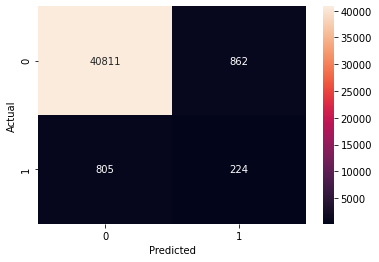

recall_score: [0.97931514 0.21768707], f1_score: [0.97998535 0.21182033]
Fold 2/4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train.shape: (250591, 15), y_train.shape: (250591,)
   feature_0  feature_1  ...  rank_feature_4  rank_feature_5
0        1.0   1.414214  ...             0.0             0.0

[1 rows x 15 columns]
X_valid.shape: (42702, 15), y_valid.shape: (42702,)
     feature_0  feature_1  ...  rank_feature_4  rank_feature_5
171     0.6629   1.151434  ...               0               0

[1 rows x 15 columns]
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.393687
[200]	valid_0's binary_logloss: 0.289568
[300]	valid_0's binary_logloss: 0.238894
[400]	valid_0's binary_logloss: 0.208369
[500]	valid_0's binary_logloss: 0.193586
[600]	valid_0's binary_logloss: 0.184235
[700]	valid_0's binary_logloss: 0.177134
[800]	valid_0's binary_logloss: 0.17094
[900]	valid_0's binary_logloss: 0.165833
[1000]	valid_0's binary_logloss: 0.159708
[1100]	valid_0's binary_logloss: 0.154726
[1200]	valid_0's binary_logloss: 0.149901
[1300]	valid_0's binary_logloss: 0.145162
[

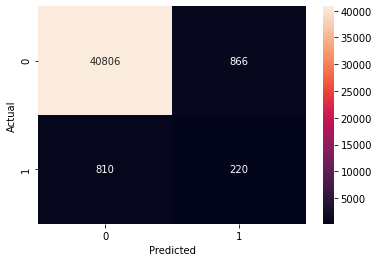

recall_score: [0.97921866 0.21359223], f1_score: [0.97987705 0.20793951]
Fold 3/4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train.shape: (250556, 15), y_train.shape: (250556,)
   feature_0  feature_1  ...  rank_feature_4  rank_feature_5
0        1.0   1.414214  ...             0.0             0.0

[1 rows x 15 columns]
X_valid.shape: (42701, 15), y_valid.shape: (42701,)
    feature_0  feature_1  ...  rank_feature_4  rank_feature_5
28   0.927099    1.36169  ...               0               0

[1 rows x 15 columns]
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.38294
[200]	valid_0's binary_logloss: 0.280512
[300]	valid_0's binary_logloss: 0.236546
[400]	valid_0's binary_logloss: 0.204868
[500]	valid_0's binary_logloss: 0.189805
[600]	valid_0's binary_logloss: 0.180291
[700]	valid_0's binary_logloss: 0.172843
[800]	valid_0's binary_logloss: 0.167181
[900]	valid_0's binary_logloss: 0.161884
[1000]	valid_0's binary_logloss: 0.156412
[1100]	valid_0's binary_logloss: 0.152462
[1200]	valid_0's binary_logloss: 0.146531
[1300]	valid_0's binary_logloss: 0.142501
[14

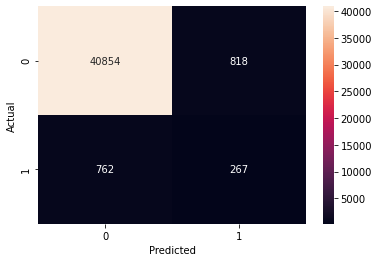

recall_score: [0.98037051 0.25947522], f1_score: [0.98102968 0.2526017 ]
Fold 4/4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train.shape: (250352, 15), y_train.shape: (250352,)
   feature_0  feature_1  ...  rank_feature_4  rank_feature_5
0   0.927099    1.36169  ...             0.0             0.0

[1 rows x 15 columns]
X_valid.shape: (42702, 15), y_valid.shape: (42702,)
   feature_0  feature_1  ...  rank_feature_4  rank_feature_5
0        1.0   1.414214  ...               0               0

[1 rows x 15 columns]
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.387976
[200]	valid_0's binary_logloss: 0.285853
[300]	valid_0's binary_logloss: 0.239085
[400]	valid_0's binary_logloss: 0.207215
[500]	valid_0's binary_logloss: 0.189017
[600]	valid_0's binary_logloss: 0.178486
[700]	valid_0's binary_logloss: 0.170706
[800]	valid_0's binary_logloss: 0.165314
[900]	valid_0's binary_logloss: 0.160064
[1000]	valid_0's binary_logloss: 0.154161
[1100]	valid_0's binary_logloss: 0.147734
[1200]	valid_0's binary_logloss: 0.142395
[1300]	valid_0's binary_logloss: 0.13776
[1400

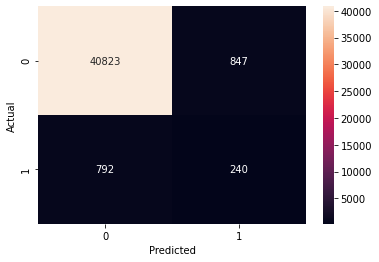

recall_score: [0.97967363 0.23255814], f1_score: [0.98032059 0.22652194]


In [0]:

cols_to_drop = ['example_id', 'target', 'CorrectString', 'CorrectString_short', 'CandidateString']
# get only features from train data
X = train.drop(cols_to_drop, axis=1, errors='ignore')
y = train['target'].values
g = train['example_id'].values

# get only features from test data
X_test = test.drop(cols_to_drop, axis=1, errors='ignore')
id_test = test['example_id'].values


print(f'X.shape: {X.shape}, y.shape: {y.shape}')
print(f'X_test.shape: {X_test.shape}')

n_features = X.shape[1]

# set model config and Kfold
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_iterations ': 200,
    'max_depth': 7,
    'num_leaves': 80,
    'learning_rate': 0.01, 
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'xgboost_dart_mode': True,
    'verbose': -1, 
    'is_unbalance': False,
    'num_threads': 5
}
n_splits = 4
kf = GroupKFold(
    n_splits=n_splits)

from imblearn.over_sampling import SMOTE,ADASYN
sm = SMOTE(random_state = 33)
ad = ADASYN(random_state = 33)
for fold_i, (train_index, valid_index) in enumerate(kf.split(X, y, g)):
    print('Fold {}/{}'.format(fold_i + 1, n_splits))
    params = lgb_params.copy() 
    
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_valid, y_valid = X.iloc[valid_index], y[valid_index]
    feature_names = list(X_train.columns) 
    
    X_train, y_train = ad.fit_sample(X_train.fillna(0), y_train.ravel())


    X_train = pd.DataFrame(X_train)
    X_train.columns = feature_names
    
    
    #pd.Series(y_train).value_counts().plot.bar()
    #plt.show()
    print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
    print(X_train.head(1))
    print(f'X_valid.shape: {X_valid.shape}, y_valid.shape: {y_valid.shape}')
    print(X_valid.head(1))
    
    
    
    lgb_train = lgb.Dataset(
        X_train, 
        y_train, 
        feature_name=feature_names,
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X_valid, 
        y_valid,
        feature_name=feature_names,
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1500,
        valid_sets=[lgb_valid],
        early_stopping_rounds=100, 
        verbose_eval=100, 
    )

    

    #Evaluate model
    # print(X.loc[valid_index].head(10))
    p = model.predict(X_valid,num_iteration=model.best_iteration)
    valid_df = train.loc[valid_index]
    valid_df['pred'] = p
    #pred_df = pred_df.sort_values('pred', ascending=True).groupby('example_id')
    print(valid_df[:5])
    print(valid_df.shape)
    max_pred = valid_df.groupby(['example_id'])['pred'].transform('max')
    valid_df['pred_target'] = np.where(valid_df['pred'].eq(max_pred), 1,0)
    pred_df = valid_df.groupby('example_id').apply(lambda x: x.sort_values(['pred_target'],ascending=False))
    pred_df = pred_df[['example_id','target','pred_target','pred', 'CorrectString','CorrectString_short', 'CandidateString']]
    print(pred_df.head(10))
    
    # print performance matrix
    print('average number of candidates: ',pred_df.groupby(level='example_id')['CandidateString'].count().mean())
    prediction = pred_df.pred_target.values
    actual = pred_df.target.values
    f1_scor = f1_score(actual, prediction,average=None)
    recall_scor = recall_score(actual, prediction,average=None)
    data = {'y_Actual':actual,'y_Predicted': prediction }
    df_result = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df_result['y_Actual'], df_result['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True,fmt="d")
    
    plt.show()
    #print (confusion_matrix)
    print('recall_score: {}, f1_score: {}'.format(recall_scor,f1_scor))
    # df.groupby('A').apply(lambda x: x.sort_values(['B', 'C']))
    # valid_df = train.loc[valid_index]

# max1 = db7.groupby(['ID','Date'])['Time(in Hours)'].transform('max')
# db7['Max'] = np.where(db7['Time(in Hours)'].eq(max1), '1', '0')


In [0]:
X_train


## TRY RNN

sampled data have 10 rows and 6 cols
sampled data have 346 rows and 4 cols
                                       document_text  ...           example_id
0  Email marketing - Wikipedia <H1> Email marketi...  ...  5655493461695504401
1  The Mother ( How I Met Your Mother ) - wikiped...  ...  5328212470870865242
2  Human fertilization - wikipedia <H1> Human fer...  ...  4435104480114867852
3  List of National Football League career quarte...  ...  5289242154789678439
4  Roanoke Colony - wikipedia <H1> Roanoke Colony...  ...  5489863933082811018

[5 rows x 6 columns]


### pre-processing data

(175192, 5)


example_id  ... target
0  5655493461695504401  ...      0
1  5655493461695504401  ...      0
2  5655493461695504401  ...      0
3  5655493461695504401  ...      0
4  5655493461695504401  ...      0

[5 rows x 5 columns]

In [0]:
test.shape

(13412, 5)

('innova', 268388) ('<PAD>', 0) 1
('synchronistic', 279670) ('<PAD>', 0) 1
('synchronistic', 279905) ('<PAD>', 0) 1
('synchronistic', 279919) ('<PAD>', 0) 1



Vocabulary size=279920
Number of Documents=377208


In [0]:
tokenizer.word_index.items()

dict_items([('<UNK>', 1), ('the', 2), ('of', 3), ('and', 4), ('in', 5), ('to', 6), ('a', 7), ('is', 8), ("''", 9), ('on', 10), ('was', 11), ('for', 12), ('as', 13), ('by', 14), ('up', 15), ('with', 16), ('that', 17), ("'s", 18), ('jump', 19), ('from', 20), ('1', 21), ('who', 22), ('at', 23), ('2', 24), ('it', 25), ('when', 26), ('are', 27), ('his', 28), ('3', 29), ('he', 30), ('retrieved', 31), ('an', 32), ('edit', 33), ('be', 34), ('s', 35), ('new', 36), ('4', 37), ('5', 38), ('first', 39), ('were', 40), ('or', 41), ("'", 42), ('which', 43), ('this', 44), ('0', 45), ('not', 46), ('6', 47), ('has', 48), ('their', 49), ('also', 50), ('have', 51), ('what', 52), ('did', 53), ('one', 54), ('2017', 55), ('her', 56), ('but', 57), ('7', 58), ('they', 59), ('had', 60), ('season', 61), ('where', 62), ('10', 63), ('world', 64), ('after', 65), ('states', 66), ('all', 67), ('8', 68), ('may', 69), ('united', 70), ('time', 71), ('you', 72), ('most', 73), ('2016', 74), ('its', 75), ('she', 76), ('two

## Modelling

In [0]:
print('{} % has no word embedding'.format(round((1- np.count_nonzero(~np.isnan(embedding_matrix))/(262530*300)) *100),2))

40 % has no word embedding


In [0]:
train[:5]

example_id  ... target
0  5655493461695504401  ...      0
1  5655493461695504401  ...      0
2  5655493461695504401  ...      0
3  5655493461695504401  ...      0
4  5655493461695504401  ...      0

[5 rows x 5 columns]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    83976300    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, None, 300)    0           embedding_1[0][0]          

In [0]:
train_text

array([[     0,      0,      0, ...,   1302,    418,    675],
       [     0,      0,      0, ...,   2066,     29,     21],
       [     0,      0,      0, ...,   2067,      5,    345],
       ...,
       [     0,      0,      0, ...,    122,    108,     55],
       [     0,      0,      0, ...,    470,    395,     33],
       [     0,      0,      0, ...,  33675, 157423,  10293]], dtype=int32)

In [0]:
train_target

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
model.evaluate([train_text, train_questions], train_target)

  93/5475 [..............................] - ETA: 13:52 - loss: 0.1090

UnknownError: ignored

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict(train_text, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(train_target, predictions)*100))
print(classification_report(train_target, predictions))
pd.DataFrame(confusion_matrix(train_target, predictions))

AssertionError: ignored